# This notebook aims to test hypotheses of interest for deeper analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib import colors as mcolors
import seaborn
seaborn.set()

Reading data

In [2]:
users = pd.read_csv('Data/userlist_filt.csv')
userlists = pd.read_csv('Data/userAnimeList_filt.csv')

In [3]:
animes = pd.read_csv('Data/animelist_filt.csv')

# The first hypothesis we are going to test: Do female users watch more romance shows?
H0: mean(male) >= mean(female);
H1: mean(male) < mean(female)

In [4]:
userlists = pd.merge(
    pd.merge(userlists,users[['username','gender','stats_episodes']], on='username',how='left'),
    animes[['anime_id','genre_Romance']], on='anime_id',how='left'
)
ratings_by_gender = userlists.groupby(['username','gender']).agg(count=('username','count'))
ratings_by_gender = ratings_by_gender.groupby('gender').agg(mean=('count','mean'))

Counting the amount of romance shows watched and adjusting by the mean

In [5]:
counts = userlists.groupby(['username']).agg({'genre_Romance':'sum','stats_episodes': 'first','gender':'first'})
counts = counts[counts['stats_episodes'] != 0]
counts = pd.merge(counts, ratings_by_gender, on='gender')
counts['Romance'] = counts['genre_Romance'] / counts['mean']

Plotting

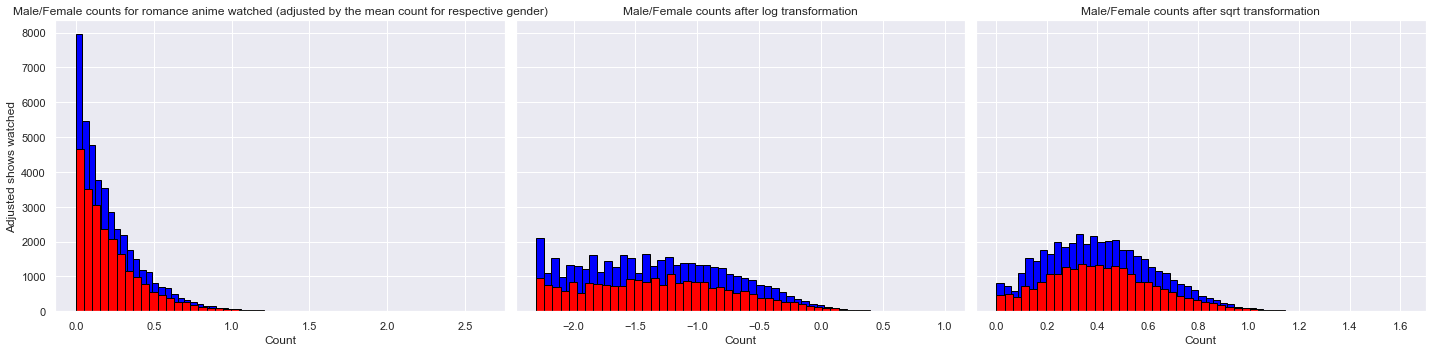

In [6]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5), sharey='row')
ax1.hist(counts[counts['gender'] == 'Male'].Romance, bins=50,color='blue',edgecolor='black',)
ax1.hist(counts[counts['gender'] == 'Female'].Romance, bins=50,color='red',edgecolor='black',)
ax1.set_title("Male/Female counts for romance anime watched (adjusted by the mean count for respective gender)")
ax1.set_xlabel('Count')
ax1.set_ylabel('Adjusted shows watched')

counts['Romance_log'] = np.log(counts['Romance']+0.1)
ax2.hist(counts[counts['gender'] == 'Male'].Romance_log, bins=50,color='blue',edgecolor='black',)
ax2.hist(counts[counts['gender'] == 'Female'].Romance_log, bins=50,color='red',edgecolor='black',)
ax2.set_title("Male/Female counts after log transformation")
ax2.set_xlabel('Count')

counts['Romance_sqrt'] = np.sqrt(counts['Romance'])
ax3.hist(counts[counts['gender'] == 'Male'].Romance_sqrt, bins=50,color='blue',edgecolor='black',)
ax3.hist(counts[counts['gender'] == 'Female'].Romance_sqrt, bins=50,color='red',edgecolor='black',)
ax3.set_title("Male/Female counts after sqrt transformation")
ax3.set_xlabel('Count')

plt.tight_layout()
plt.show()

As we can see, in order to test the hypothesis, we need to transform the data. Square root transformation seems to do well

In [7]:
statistic, p_value = stats.ttest_ind(counts[counts['gender'] == 'Male'].Romance_sqrt,counts[counts['gender'] == 'Female'].Romance_sqrt, equal_var=False)

print(f'T-test p-value: {p_value}')
print(f'T-statistic: {statistic}')
u_statistic, p_value = stats.mannwhitneyu(counts[counts['gender'] == 'Male'].Romance_sqrt, counts[counts['gender'] == 'Female'].Romance_sqrt, alternative='two-sided')
print(f'Mann-whitney P-value: {p_value}')

T-test p-value: 2.151425036825301e-07
T-statistic: -5.1865368700173615
Mann-whitney P-value: 9.856001275620036e-06


With these results, we can conclude that there is a significant difference between the amount of romance shows watched by male and female users with the negative t-statistic indicating that female users have a higher mean

# The second hypothesis from the data exploration notebook: Is there a relationship between having zero mean rating and having no episodes watched?
This could be the case for some users to intentionally disrupt ratings by creating throwaway accounts.

In [8]:
zerolists = users[['username','stats_episodes','stats_mean_score']]
zerolists = zerolists[zerolists['stats_mean_score'] == 0]
zerolists_zero_episodes = zerolists[zerolists['stats_episodes'] == 0]

In [9]:
total_zero_mean = len(zerolists)
zero_mean_zero_episodes = len(zerolists_zero_episodes)
zero_mean_non_zero_episodes = total_zero_mean - zero_mean_zero_episodes

contingency_table = pd.DataFrame({
    'Zero Episodes': [zero_mean_zero_episodes, len(users) - total_zero_mean],
    'Non-Zero Episodes': [zero_mean_non_zero_episodes, len(users) - len(zerolists)]
}, index=['Zero Mean Score', 'Other'])

contingency_table

,Zero Episodes,Non-Zero Episodes
Zero Mean Score,1704,1530
Other,65050,65050


In [10]:
chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
print(f'Chi-squared Statistic: {chi2}')
print(f'P-value: {p_value}')

Chi-squared Statistic: 9.02743780716443
P-value: 0.002659569997732597


The p-value indicates that there is a very significant relationship between having zero episodes watched and having zero mean rating, this fits into our initial guess about fake accounts. Further investigation seems impossible without having more data.

# Third test: Is there a trend of ratings increasing for newer shows? 

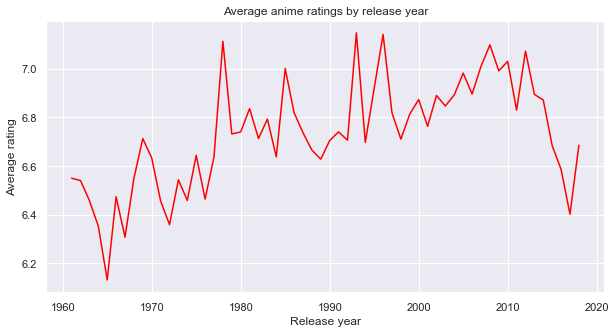

In [11]:
animes['release_year'] = animes['premiered'].str.extract(r'(\d{4})')
animes['release_year'] = pd.to_numeric(animes['release_year'], errors='coerce')
animes = animes.dropna(subset=['release_year'])
animes = animes[animes['release_year'] != 2019]
animes = animes[animes['score'] != 0]
average_ratings = animes.groupby('release_year').agg(mean=('score','mean')).reset_index()
plt.figure(figsize=(10, 5))
seaborn.lineplot(data=average_ratings, x='release_year', y='mean',color='Red')
plt.title('Average anime ratings by release year')
plt.xlabel('Release year')
plt.ylabel('Average rating')
plt.grid(True)
plt.show()

In [12]:
correlation = average_ratings['release_year'].corr(average_ratings['mean'])
print(f'Correlation coefficient: {correlation}')

Correlation coefficient: 0.5907558971412697


With this correlation coefficient, we can conclude that there is a moderate positive correlation between the release year and the rating shows usually get

In [43]:
# Fourth Test: Is there a genuine difference in score user score based on what was the original source material?


In [44]:

sources = animes['source'].unique()
grouped_ratings = [animes[animes['source'] == source]['score'] for source in sources]



In [45]:
f_stat, p_value = stats.f_oneway(*grouped_ratings)


In [46]:
print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

F-statistic: 71.60862350570285
P-value: 1.518480351330097e-193


In [47]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [48]:
tukey = pairwise_tukeyhsd(endog=animes['score'], groups=animes['source'], alpha=0.05)


In [49]:
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: -268.55519315953967
P-value: 1.518480351330097e-193


the p value shows there is a significant difference between some sources therefore we must do a posthoc analysis

In [50]:
print(tukey)


       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower   upper  reject
------------------------------------------------------------------
 4-koma manga          Book  -0.0194    1.0 -0.6035  0.5648  False
 4-koma manga     Card game  -0.1055    1.0 -0.6555  0.4445  False
 4-koma manga Digital manga  -1.4997 0.0018 -2.6938 -0.3057   True
 4-koma manga          Game  -0.2012 0.7985 -0.5383  0.1358  False
 4-koma manga   Light novel   0.5142    0.0   0.197  0.8313   True
 4-koma manga         Manga   0.4198    0.0  0.1427   0.697   True
 4-koma manga         Music  -0.4673 0.9235  -1.367  0.4325  False
 4-koma manga         Novel   0.3328 0.1429 -0.0393  0.7049  False
 4-koma manga      Original  -0.2907 0.0343  -0.572 -0.0095   True
 4-koma manga         Other  -0.5491 0.0002 -0.9415 -0.1567   True
 4-koma manga  Picture book  -1.2688    0.0 -1.7824 -0.7552   True
 4-koma manga         Radio  -0.7864 0.8942 -2.2368   0.664  F

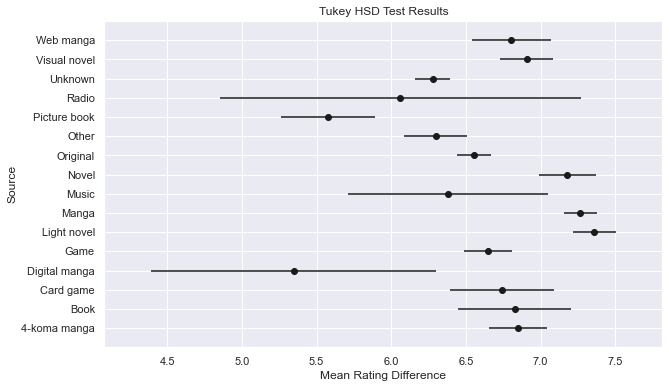

In [51]:
tukey.plot_simultaneous()
plt.xlabel('Mean Rating Difference')
plt.ylabel('Source')
plt.title('Tukey HSD Test Results')
plt.show()

From these results the original source material has a clear impact on the shows overall user score.
While there is not enough evidence to suggest there is a differnce between light novels, novels and manga, there is a clear difference between them and things like card games, originals and visual novels.
